# Installs and Imports

In [1]:
!pip install decord # for video reader

     |████████████████████████████████| 13.6 MB 75 kB/s 


In [1]:
import os
import cv2
import time
import psutil # for cpu usage
import decord # for video reder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!gdown "https://drive.google.com/uc?export=download&id=1tyYicRjjYHq1IwTSC0Loa9uE03BUWu5D"
!unzip wave_test.zip
!rm wave_test.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1tyYicRjjYHq1IwTSC0Loa9uE03BUWu5D
To: /content/wave_test.zip
46.6MB [00:01, 36.7MB/s]
Archive:  wave_test.zip
replace DD_Net.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: DD_Net.py               
replace models/DD_Net_large_14.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: models/DD_Net_large_14.h5  
replace wave/1.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wave/1.mp4              
  inflating: wave/10.mp4             
  inflating: wave/11.mp4             
  inflating: wave/12.mp4             
  inflating: wave/13.mp4             
  inflating: wave/14.mp4             
  inflating: wave/15.mp4             
  inflating: wave/16.mp4             
  inflating: wave/17.mp4             
  inflating: wave/18.mp4             
  inflating: wave/19.mp4             
replace wave/2.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wave/2.mp4              
  inflating: wave/20.mp4         

### For Mediapipe

In [4]:
!pip install mediapipe

     |████████████████████████████████| 30.4 MB 77 kB/s 


In [2]:
import mediapipe as mp
import tensorflow as tf
from scipy.spatial.distance import cdist

In [3]:
from DD_Net import build_DD_Net, C, LABELS

### For TSM

In [5]:
import torch
import torchvision

In [8]:
!git clone https://github.com/mit-han-lab/temporal-shift-module.git

Cloning into 'temporal-shift-module'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 237 (delta 3), reused 1 (delta 0), pack-reused 226
Receiving objects: 100% (237/237), 250.28 KiB | 2.20 MiB/s, done.
Resolving deltas: 100% (106/106), done.
/content/temporal-shift-module/online_demo
/content


In [6]:
%cd temporal-shift-module/online_demo/
from mobilenet_v2_tsm import MobileNetV2
%cd /content/

/content/temporal-shift-module/online_demo
/content


# Functions and Variables

In [8]:
SEQUENCE_LENGTH_MEDIAPIPE = 32
SEQUENCE_LENGTH_TSM = SEQUENCE_LENGTH_MEDIAPIPE#10
FRAME_WIDTH = 1080
FRAME_HEIGHT = 720

### For Mediapipe

In [9]:
def mediapipe_detection(image, model):
    image_np = image.numpy()
    image_np.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image_np)                 # Make prediction
    #image_np.flags.writeable = True                   # Image is now writeable
    return results

In [10]:
def convert_mediapipe_for_DDNet(hand): # add 1 point to 22 points for DDnet and return DDnet input
    # let missing point be in the middle of neighbours
    c1_x = (hand[0, 0] + hand[9, 0]) / 2
    c1_y = (hand[0, 1] + hand[9, 1]) / 2
    c1_z = (hand[0, 2] + hand[9, 2]) / 2

    c2_x = (hand[0, 0] + hand[13, 0]) / 2
    c2_y = (hand[0, 1] + hand[13, 1]) / 2
    c2_z = (hand[0, 2] + hand[13, 2]) / 2

    c_x = (c1_x + c2_x) / 2
    c_y = (c1_y + c2_y) / 2
    c_z = (c1_z + c2_z) / 2
    new_hand = np.insert(hand, 1, [c_x, c_y, c_z], axis=0)

    # create second part of model input
    dist = cdist(new_hand, new_hand)
    JCD = []
    for i, d in enumerate(dist):
        JCD.extend(dist.T[i, i + 1:])

    return JCD, new_hand

In [11]:
def prepere_DDNet_inputs(results): # return hand with larger score or empty array
    if results.multi_hand_landmarks:
        scores = [i.classification[0].score for i in results.multi_handedness]
        hand = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[np.argmax(scores)].landmark])
        keypoints_0, keypoints_1 = convert_mediapipe_for_DDNet(hand) 
    else:
        keypoints_0, keypoints_1 = np.zeros((231)), np.zeros((22, 3))

    return  keypoints_0, keypoints_1

In [12]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)
# Load the gesture recognizer model
DD_Net.load_weights('models/DD_Net_large_14.h5')

### For TSM

In [13]:
def get_executor(use_gpu=True):
    device = 'cuda' if use_gpu and torch.cuda.is_available() else 'cpu'
    torch_module = MobileNetV2(n_class=27)
    if not os.path.exists("mobilenetv2_jester_online.pth.tar"):  # checkpoint not downloaded
        print('Downloading PyTorch checkpoint...')
        import urllib.request
        url = 'https://hanlab.mit.edu/projects/tsm/models/mobilenetv2_jester_online.pth.tar'
        urllib.request.urlretrieve(url, './mobilenetv2_jester_online.pth.tar')
    torch_module.load_state_dict(torch.load("mobilenetv2_jester_online.pth.tar"))
    torch_inputs = (#torch.rand(1, 3, 224, 224).to(device),
                    torch.zeros([1, 3, 56, 56]).to(device),
                    torch.zeros([1, 4, 28, 28]).to(device),
                    torch.zeros([1, 4, 28, 28]).to(device),
                    torch.zeros([1, 8, 14, 14]).to(device),
                    torch.zeros([1, 8, 14, 14]).to(device),
                    torch.zeros([1, 8, 14, 14]).to(device),
                    torch.zeros([1, 12, 14, 14]).to(device),
                    torch.zeros([1, 12, 14, 14]).to(device),
                    torch.zeros([1, 20, 7, 7]).to(device),
                    torch.zeros([1, 20, 7, 7]).to(device))
    torch_module.to(device)
    return torch_module, torch_inputs

In [14]:
def process_output(idx_, history):
    # idx_: the output of current frame
    # history: a list containing the history of predictions
    
    # mask out illegal action
    if idx_ in [7, 8, 21, 22, 3]:
        idx_ = history[-1]

    # use only single no action class
    if idx_ == 0:
        idx_ = 2

    # history smoothing
    if idx_ != history[-1]:
        if not (history[-1] == history[-2]) and (history[-2] == history[-3]):
            idx_ = history[-1]

    history.append(idx_)
    return history[-1], history

In [15]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [16]:
LABELS_TSM = [
    "Doing other things",  # 0
    "Drumming Fingers",  # 1
    "No gesture",  # 2
    "Pulling Hand In",  # 3
    "Pulling Two Fingers In",  # 4
    "Pushing Hand Away",  # 5
    "Pushing Two Fingers Away",  # 6
    "Rolling Hand Backward",  # 7
    "Rolling Hand Forward",  # 8
    "Shaking Hand",  # 9
    "Sliding Two Fingers Down",  # 10
    "Sliding Two Fingers Left",  # 11
    "Sliding Two Fingers Right",  # 12
    "Sliding Two Fingers Up",  # 13
    "Stop Sign",  # 14
    "Swiping Down",  # 15
    "Swiping Left",  # 16
    "Swiping Right",  # 17
    "Swiping Up",  # 18
    "Thumb Down",  # 19
    "Thumb Up",  # 20
    "Turning Hand Clockwise",  # 21
    "Turning Hand Counterclockwise",  # 22
    "Zooming In With Full Hand",  # 23
    "Zooming In With Two Fingers",  # 24
    "Zooming Out With Full Hand",  # 25
    "Zooming Out With Two Fingers"  # 26
]


### def mediapipe_test()

In [17]:
def mediapipe_test(files_folder, device='cpu', flip=True, first=False):
  process = psutil.Process(os.getpid())
  decord.bridge.set_bridge('tensorflow')
  mp_predictions = []
  mp_pred_confidence = []
  mp_pred_class = []
  mp_speed = []
  mp_gpu_memory_usage = []
  mp_cpu_memory_usage = []
  mp_video_path = []
  mp_video_len = []
  mp_hands = mp.solutions.hands
  # for each video in folder
  for video_name in os.listdir(files_folder):
    video_path = os.path.join(files_folder, video_name)
    preMemory_cpu = process.memory_info()[0]
    preTime = time.time()
    # download video
    vr = decord.VideoReader(video_path, ctx=decord.cpu(0), width=FRAME_WIDTH, height=FRAME_HEIGHT)
    # chose frames to process
    video_len = len(vr)
    video_idx_seq = [int(i*(video_len-1)/(SEQUENCE_LENGTH_MEDIAPIPE-1)) for i in range(SEQUENCE_LENGTH_MEDIAPIPE)]
    X_1, X_0 = [], []
    with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands=2) as hands:
      for i in video_idx_seq:
        # Flip the frame vertically
        frame = tf.image.flip_left_right(vr[i]) if flip else vr[i]
        # Get hand landmark prediction
        results = mediapipe_detection(frame, hands)
        # prepare DDNet input from hand landmarks
        keypoints_0, keypoints_1 = prepere_DDNet_inputs(results)
        X_0.append(keypoints_0)
        X_1.append(keypoints_1)

    # Place tensors on the CPU/GPU
    with tf.device('/device:{}:0'.format(device.upper())):
      preMemory_gpu = tf.config.experimental.get_memory_info('GPU:0')['current'] if tf.config.list_physical_devices('GPU') else 0
      input = [tf.convert_to_tensor(np.expand_dims(np.array(X_0), axis=0)),
               tf.convert_to_tensor(np.expand_dims(np.array(X_1), axis=0))]
      # Get gesture prediction
      pred  = DD_Net.predict(input)[0]
      if first:
        return ''
      curMemory_gpu = tf.config.experimental.get_memory_info('GPU:0')['current'] if tf.config.list_physical_devices('GPU') else 0
    
    max_idx = np.argmax(pred) # chose max cocfident class 

    # create table with results  
    curTime = time.time()
    curMemory_cpu = process.memory_info()[0] 
    
    mp_predictions.append(max_idx)
    mp_pred_confidence.append(pred[max_idx])
    mp_pred_class.append(LABELS[max_idx])
    
    mp_speed.append((curTime - preTime))
    mp_cpu_memory_usage.append((curMemory_cpu - preMemory_cpu))
    mp_gpu_memory_usage.append((curMemory_gpu - preMemory_gpu))

    mp_video_path.append(video_path)
    mp_video_len.append(video_len)
  
  mp_dict = {'video_path': mp_video_path, 
             'video_len': mp_video_len,
             'precessed_frames': SEQUENCE_LENGTH_MEDIAPIPE, 
             'pred_id': mp_predictions, 
             'pred_class': mp_pred_class, 
             'conf': mp_pred_confidence, 
             'true_class': 'WAVE', 
             'speed': mp_speed, 
             'cpu_memory_used': mp_cpu_memory_usage, 
             'gpu_memory_used': mp_gpu_memory_usage, 
             'flip_image': flip,
             'GPU': device!='cpu',
             'method': 'cpu_mediapipe_and_DDnet'}

  return pd.DataFrame(mp_dict)

### def tsm_test()

In [18]:
def tsm_test(files_folder, device='cpu', flip=True, first=False):
  process = psutil.Process(os.getpid())
  decord.bridge.set_bridge('torch')
  tsm_predictions = []
  tsm_pred_confidence = []
  tsm_pred_class = []
  tsm_speed = []
  tsm_gpu_memory_usage = []
  tsm_cpu_memory_usage = []
  tsm_video_path = []
  tsm_video_len = []
  # for each video in folder
  for video_name in os.listdir(files_folder):
    idx = 2
    conf = 0
    history = [2, 2] # history of predictions
    video_path = os.path.join(files_folder, video_name)
    preMemory_cpu = process.memory_info()[0]
    
    preMemory_gpu = torch.cuda.memory_allocated(0) if torch.cuda.is_available() else 0
    model, buffer = get_executor(False if device=='cpu' else True)
    model.eval()
    preTime = time.time()
    # download video
    vr = decord.VideoReader(video_path, ctx=decord.cpu(0), width=FRAME_WIDTH, height=FRAME_HEIGHT)
    # chose frames to process
    video_len = len(vr)
    video_idx_seq = [int(i*(video_len-1)/(SEQUENCE_LENGTH_TSM-1)) for i in range(SEQUENCE_LENGTH_TSM)]
    with torch.no_grad():
        for i in video_idx_seq:
            # Flip the frame vertically
            if device == 'gpu':
              frame = torch.flip(vr[i].to('cuda'), [1]) if flip else vr[i].to('cuda')
            else:
              frame = torch.flip(vr[i], [1]) if flip else vr[i]
            # Get gesture prediction
            img_tran = transform(frame.permute(2, 0, 1).float().div(255))
            input_var = img_tran.view(1, 3, img_tran.size(1), img_tran.size(2))
            outputs = model(input_var, *buffer)
            feat, buffer = outputs[0], outputs[1:]
            feat = feat.detach()
            softmax_feat = torch.nn.functional.softmax(feat[0],dim=0)
            idx = np.argmax(softmax_feat.cpu().numpy(), axis=0)
            idx, history = process_output(idx, history)
            if first:
              return ''
    curMemory_gpu = torch.cuda.memory_allocated(0) if torch.cuda.is_available() else 0
    
    curTime = time.time()
    curMemory_cpu = process.memory_info()[0]
    
    history = history[11:] if SEQUENCE_LENGTH_TSM > 10 else history[2:]
    pred_pairs = [[i,history.count(i)] for i in set(history)]
    pred_pairs.sort(key=lambda x: x[1])
    if len(pred_pairs) > 1 and pred_pairs[-1][1] > 2*pred_pairs[-2][1]:
      final_prediction = pred_pairs[-1]
    else:
      final_prediction =  pred_pairs[-2]
    
    tsm_predictions.append(final_prediction[0])
    tsm_pred_confidence.append(final_prediction[1]/sum([i[1] for i in pred_pairs[-2:]]))
    tsm_pred_class.append(LABELS_TSM[final_prediction[0]])
    
    tsm_speed.append((curTime - preTime))
    tsm_cpu_memory_usage.append((curMemory_cpu - preMemory_cpu))
    tsm_gpu_memory_usage.append((curMemory_gpu - preMemory_gpu))

    tsm_video_path.append(video_path)
    tsm_video_len.append(video_len)
    
    if device == "gpu":
      torch.cuda.empty_cache()
  
  tsm_dict = {'video_path': tsm_video_path, 
             'video_len': tsm_video_len, 
             'precessed_frames': SEQUENCE_LENGTH_TSM, 
             'pred_id': tsm_predictions, 
             'pred_class': tsm_pred_class, 
             'conf': tsm_pred_confidence, 
             'true_class': 'WAVE', 
             'speed': tsm_speed, 
             'cpu_memory_used': tsm_cpu_memory_usage, 
             'gpu_memory_used': tsm_gpu_memory_usage, 
             'flip_image': flip,
             'GPU': device!='cpu',
             'method': 'tsm_MobileNetV2'}

  return pd.DataFrame(tsm_dict)

# Results

In [19]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3905006981973288003
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8044856553297942118
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [20]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


### For Mediapipe

In [21]:
# First time a bit slow
mediapipe_test('wave', first=True)
mediapipe_test('wave', 'gpu', first=True)

''

In [22]:
mp_cpu_df_no_flip = mediapipe_test('wave', flip=False)
mp_cpu_df_flip = mediapipe_test('wave')

In [23]:
mp_gpu_df_no_flip = mediapipe_test('wave', 'gpu', flip=False)
mp_gpu_df_flip = mediapipe_test('wave', 'gpu')

### For TSM

In [24]:
# First time a bit slow
tsm_test('wave', first=True)
tsm_test('wave', 'gpu', first=True)

''

In [25]:
tsm_cpu_df_no_flip = tsm_test('wave', flip=False)
tsm_cpu_df_flip = tsm_test('wave')

In [26]:
tsm_gpu_df_no_flip = tsm_test('wave', 'gpu', flip=False)
tsm_gpu_df_flip = tsm_test('wave', 'gpu')

### Create DataFrame

In [27]:
results = pd.concat([mp_cpu_df_flip, mp_cpu_df_no_flip, mp_gpu_df_flip, mp_gpu_df_no_flip,
                     tsm_cpu_df_flip, tsm_cpu_df_no_flip, tsm_gpu_df_flip, tsm_gpu_df_no_flip], ignore_index=True)

In [28]:
results.to_csv('result.csv', index=False)

# Data analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('result.csv')
df

,video_path,video_len,precessed_frames,pred_id,pred_class,conf,true_class,speed,cpu_memory_used,gpu_memory_used,flip_image,method,GPU
0,wave/28.mp4,40,32,12,Swipe V,0.457265,WAVE,1.496724,36864,0,True,cpu_mediapipe_and_DDnet,False
1,wave/4.mp4,40,32,8,Swipe Up,0.439130,WAVE,1.617949,0,0,True,cpu_mediapipe_and_DDnet,False
2,wave/12.mp4,40,32,8,Swipe Up,0.477755,WAVE,1.540751,12288,0,True,cpu_mediapipe_and_DDnet,False
3,wave/23.mp4,39,32,8,Swipe Up,0.642428,WAVE,1.374905,0,0,True,cpu_mediapipe_and_DDnet,False
4,wave/7.mp4,42,32,8,Swipe Up,0.367127,WAVE,1.403522,3301376,0,True,cpu_mediapipe_and_DDnet,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,wave/13.mp4,39,32,2,No gesture,0.909091,WAVE,0.667826,0,0,False,tsm_MobileNetV2,True
260,wave/24.mp4,37,32,14,Stop Sign,0.809524,WAVE,0.603985,0,0,False,tsm_MobileNetV2,True
261,wave/31.mp4,39,32,2,No gesture,0.777778,WAVE,0.608812,0,0,False,tsm_MobileNetV2,True
262,wave/8.mp4,42,32,17,Swiping Right,0.384615,WAVE,0.607919,0,0,False,tsm_MobileNetV2,True


In [60]:
df[df.cpu_memory_used<0].groupby(by=['method', 'GPU']).cpu_memory_used.count()

method           GPU 
tsm_MobileNetV2  True    1
Name: cpu_memory_used, dtype: int64

In [62]:
df[df.cpu_memory_used==0].groupby(by=['method', 'GPU']).cpu_memory_used.count()

method                   GPU  
cpu_mediapipe_and_DDnet  False    18
                         True     29
tsm_MobileNetV2          False    46
                         True     58
Name: cpu_memory_used, dtype: int64

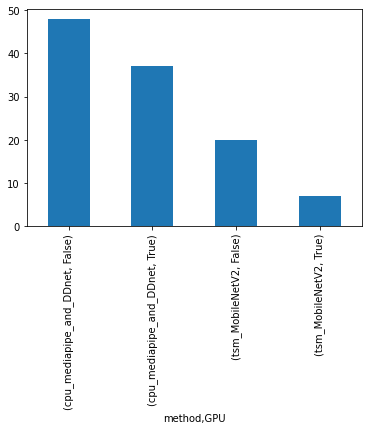

In [38]:
df[df.cpu_memory_used>0].groupby(by=['method', 'GPU']).cpu_memory_used.count().plot(kind='bar')

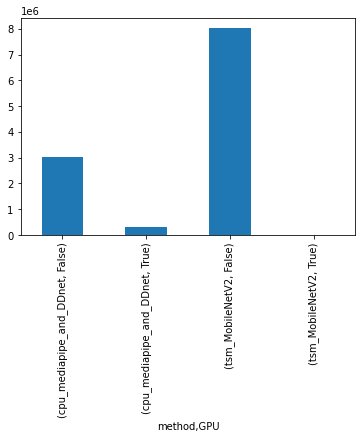

In [37]:
df[df.cpu_memory_used>0].groupby(by=['method', 'GPU']).cpu_memory_used.mean().plot(kind='bar')

In [63]:
df[df.gpu_memory_used==0].groupby(by=['method', 'GPU']).gpu_memory_used.count()

method                   GPU  
cpu_mediapipe_and_DDnet  False    66
                         True      3
tsm_MobileNetV2          False    66
                         True     58
Name: gpu_memory_used, dtype: int64

In [58]:
df[df.gpu_memory_used<0].groupby(by=['method', 'GPU']).gpu_memory_used.count()

method                   GPU 
cpu_mediapipe_and_DDnet  True    11
tsm_MobileNetV2          True     3
Name: gpu_memory_used, dtype: int64

In [41]:
df[df.gpu_memory_used>0].groupby(by=['method', 'GPU']).gpu_memory_used.count()

method                   GPU 
cpu_mediapipe_and_DDnet  True    52
tsm_MobileNetV2          True     5
Name: gpu_memory_used, dtype: int64

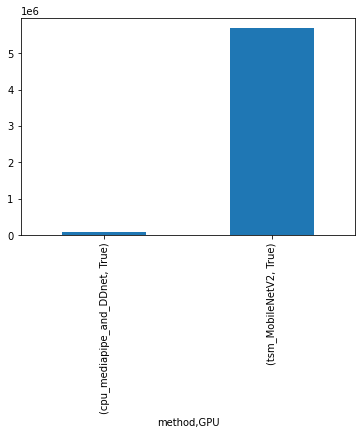

In [39]:
df[df.gpu_memory_used>0].groupby(by=['method', 'GPU']).gpu_memory_used.mean().plot(kind='bar')

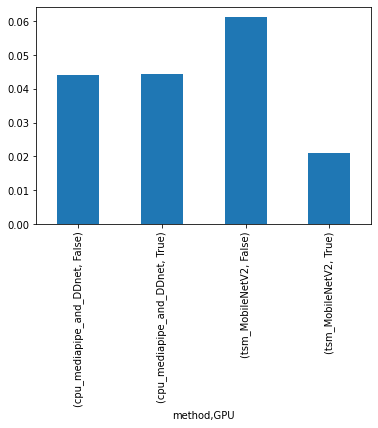

In [49]:
df.groupby(by=['method', 'GPU']).apply(lambda x: (x.speed/x.precessed_frames).mean()).plot(kind='bar')

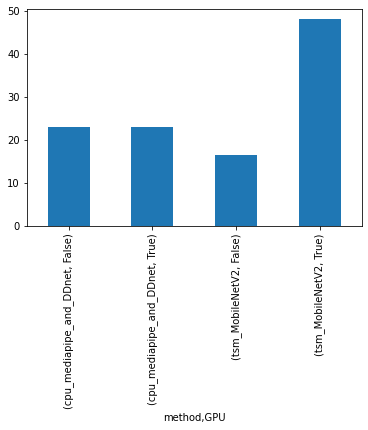

In [50]:
#fps
df.groupby(by=['method', 'GPU']).apply(lambda x: (x.precessed_frames/x.speed).mean()).plot(kind='bar')

In [53]:
df.groupby(by=['method', 'GPU']).apply(lambda x: (x.precessed_frames/x.speed).describe())

count       mean  ...        75%        max
method                  GPU                      ...                      
cpu_mediapipe_and_DDnet False   66.0  23.034612  ...  24.244513  39.321627
                        True    66.0  22.961750  ...  24.046646  39.380802
tsm_MobileNetV2         False   66.0  16.459237  ...  17.839958  19.158634
                        True    66.0  48.146249  ...  51.715893  65.720293

[4 rows x 8 columns]

In [57]:
df.groupby(by=['method', 'flip_image']).apply(lambda x: x.pred_class.value_counts())

method                   flip_image                            
cpu_mediapipe_and_DDnet  False       Swipe Up                      26
                                     Swipe Right                   18
                                     Swipe Down                     6
                                     Swipe X                        4
                                     Shake                          4
                                     Rotation Counter Clockwise     4
                                     Tap                            2
                                     Swipe V                        2
                         True        Swipe Up                      28
                                     Swipe Right                   22
                                     Swipe X                        4
                                     Rotation Counter Clockwise     4
                                     Tap                            2
                          

# Build Mediapipe with GPU
### We can build but not use:
```
import mediapipe as mp 
hands = mp.solutions.hands
```
```AttributeError: module 'mediapipe' has no attribute 'solutions'```

In [ ]:
!apt-get update
!apt-get install gcc-8 g++-8

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

In [ ]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-8 1

update-alternatives: using /usr/bin/gcc-8 to provide /usr/bin/gcc (gcc) in auto mode


In [ ]:
!dpkg -l | grep gcc | awk '{print $2}'

gcc
gcc-7
gcc-7-base:amd64
gcc-8
gcc-8-base:amd64
lib32gcc1
libgcc-7-dev:amd64
libgcc-8-dev:amd64
libgcc1:amd64


In [ ]:
!npm install -g @bazel/bazelisk

/tools/node/bin/bazelisk -> /tools/node/lib/node_modules/@bazel/bazelisk/bazelisk.js
/tools/node/bin/bazel -> /tools/node/lib/node_modules/@bazel/bazelisk/bazelisk.js
+ @bazel/bazelisk@1.10.1
added 1 package in 2.343s


In [ ]:
!echo $HOME

/root


In [ ]:
%cd /root/

/root


In [ ]:
!git clone https://github.com/google/mediapipe.git
%cd mediapipe

Cloning into 'mediapipe'...
remote: Enumerating objects: 10800, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 10800 (delta 7), reused 20 (delta 5), pack-reused 10742
Receiving objects: 100% (10800/10800), 511.78 MiB | 30.35 MiB/s, done.
Resolving deltas: 100% (7594/7594), done.
Checking out files: 100% (2346/2346), done.
/root/mediapipe


In [ ]:
!apt-get install mesa-common-dev libegl1-mesa-dev libgles2-mesa-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libegl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libegl1-mesa-dev set to manually installed.
libgles2-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgles2-mesa-dev set to manually installed.
mesa-common-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
mesa-common-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


In [ ]:
!apt-get install -y libprotobuf-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libprotobuf-lite10
The following NEW packages will be installed:
  libprotobuf-dev libprotobuf-lite10
0 upgraded, 2 newly installed, 0 to remove and 80 not upgraded.
Need to get 1,056 kB of archives.
After this operation, 8,482 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf-lite10 amd64 3.0.0-9.1ubuntu1 [97.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf-dev amd64 3.0.0-9.1ubuntu1 [959 kB]
Fetched 1,056 kB in 1s (953 kB/s)
Selecting previously unselected package libprotobuf-lite10:amd64.
(Reading database ... 156047 files and directories currently installed.)
Preparing to unpack .../libprotobuf-lite10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotobuf-lite10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package libprotobuf-dev:amd6

In [ ]:
!apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


In [ ]:
!ls

build_android_examples.sh  docs		     setup_android_sdk_and_ndk.sh
BUILD.bazel		   LICENSE	     setup_opencv.sh
build_desktop_examples.sh  MANIFEST.in	     setup.py
build_ios_examples.sh	   mediapipe	     third_party
CONTRIBUTING.md		   README.md	     WORKSPACE
Dockerfile		   requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd /root/mediapipe/

/root/mediapipe


In [ ]:
!python setup.py gen_protos

running gen_protos
adding __init__ file: /root/mediapipe/mediapipe/calculators/__init__.py
adding __init__ file: /root/mediapipe/mediapipe/modules/__init__.py
adding __init__ file: /root/mediapipe/mediapipe/modules/holistic_landmark/__init__.py
adding __init__ file: /root/mediapipe/mediapipe/modules/objectron/__init__.py
adding __init__ file: /root/mediapipe/mediapipe/framework/__init__.py
generating proto file: mediapipe/framework/packet_generator_pb2.py
generating proto file: mediapipe/framework/calculator_profile_pb2.py
generating proto file: mediapipe/framework/mediapipe_options_pb2.py
generating proto file: mediapipe/framework/calculator_options_pb2.py
generating proto file: mediapipe/framework/status_handler_pb2.py
generating proto file: mediapipe/framework/thread_pool_executor_pb2.py
generating proto file: mediapipe/framework/test_calculators_pb2.py
generating proto file: mediapipe/framework/packet_factory_pb2.py
generating proto file: mediapipe/framework/calculator_pb2.py
gener

In [ ]:
!python setup.py install --link-opencv 

Streaming output truncated to the last 5000 lines.
copying mediapipe/objc/MPPInputSource.m -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPLayerRenderer.h -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPLayerRenderer.m -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPPlayerInputSource.h -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPPlayerInputSource.m -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPTimestampConverter.h -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/MPPTimestampConverter.mm -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/NSError+util_status.h -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/NSError+util_status.mm -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/Weakify.h -> build/lib.linux-x86_64-3.7/mediapipe/objc
copying mediapipe/objc/util.cc -> build/lib.linux-x86_64-3.7/med

In [ ]:
import mediapipe as mp

In [ ]:
import os
os.environ['GLOG_logtostderr'] = '1'